In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Linear Regression (线性回归),
与前面谈到的逻辑回归不同，线性回归预测的是连续的数值，可以用此公式表示：$f(w,x)=w^Tx=y$，其中w和x分别代表权重以及输入，而w是我们要优化的变量。首先，先构造一个误差函数$\sum_{i}^{N}(y_i-w^Tx_i)^2$，此误差函数为一种凸函数，其最低点，也就是微分后为0的点为最优点，故能直接带入公式求极值$\hat{w}=(x^Tx)^{-1}x^Ty$，此称为最下二乘法，然而，如果需要训练的数据量非常大，在计算反矩阵将会消耗非常大量的计算资源，故一般使用牛顿法进行优化

### 优缺点

优点：对结果可解释性高、计算量少  
缺点：不适合处理非线性数据

接下来我们对最小二乘法以及梯度下降法法进行演示

In [2]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def standRegres(xArr,yArr):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat)
    return ws
xs,ys = loadDataSet('datasets/ex0.txt')
ws=standRegres(xs,ys)
ws

matrix([[3.00774324],
        [1.69532264]])

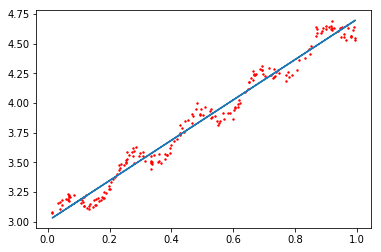

In [3]:
xMat=np.mat(xs)
yMat=np.mat(ys)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0],s=2,c='red')
yHat=xMat*ws
ax.plot(xMat[:,1],yHat)
plt.show()

In [4]:
np.corrcoef(yHat.T,yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

以上是直接求极值对结果，从最后画的图来看还算满准确的，numpy有提供求相关系数的API，可以直接调用，我们预测出的y以及实际的label相关性高达0.98
接下来，为了解决回归难以处理非线性问题，我们使用LWLR方法，与之前SVM的核方法(kernel)相似
$$
w=exp\left ( \frac{|x^i-x|}{-2k^2} \right )
$$

In [5]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat
xs,ys = loadDataSet('datasets/ex0.txt')
lwlr(xs[0],xs,ys,1.0), lwlr(xs[0],xs,ys,0.001)

(matrix([[3.12204471]]), matrix([[3.20175729]]))

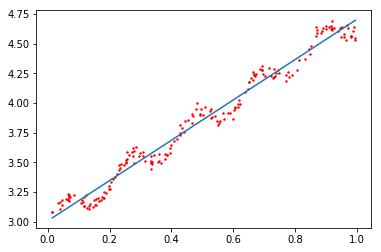

In [6]:
yHat=lwlrTest(xs, xs, ys, 1.0)
xMat=np.mat(xs)
srtIdx=xMat[:,1].argsort(0)
xSort=xMat[srtIdx][:,0,:]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],np.mat(ys).T.flatten().A[0],s=2,c='red')
ax.plot(xSort[:,1],yHat[srtIdx])
plt.show()

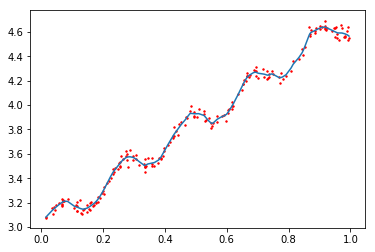

In [7]:
yHat=lwlrTest(xs, xs, ys, 0.01)
xMat=np.mat(xs)
srtIdx=xMat[:,1].argsort(0)
xSort=xMat[srtIdx][:,0,:]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],np.mat(ys).T.flatten().A[0],s=2,c='red')
ax.plot(xSort[:,1],yHat[srtIdx])
plt.show()

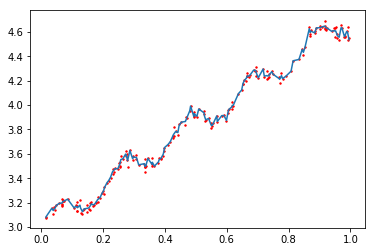

In [8]:
yHat=lwlrTest(xs, xs, ys, 0.003)
xMat=np.mat(xs)
srtIdx=xMat[:,1].argsort(0)
xSort=xMat[srtIdx][:,0,:]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],np.mat(ys).T.flatten().A[0],s=2,c='red')
ax.plot(xSort[:,1],yHat[srtIdx])
plt.show()

接下来我们利用预测鲍鱼的年龄来解释避免回归过拟合的方法-ridge regression和lasso regression

In [11]:
def errorfc(yArr,yHatArr): # yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()
xs,ys = loadDataSet('datasets/abalone.txt')
yHat0_1=lwlrTest(xs[0:99],xs[0:99],ys[0:99],0.1)
yHat1_0=lwlrTest(xs[0:99],xs[0:99],ys[0:99],1)
yHat10_0=lwlrTest(xs[0:99],xs[0:99],ys[0:99],10)

In [12]:
errorfc(ys[0:99],yHat0_1.T),errorfc(ys[0:99],yHat1_0.T),errorfc(ys[0:99],yHat10_0.T)

(56.78868743048742, 429.8905618704059, 549.1181708828803)

可以看到，kernel值越小，误差越小，我们何不使用尽可能小的kernel值呢？太小的kernel值容易造成过拟合，我们接下来看看精准度

In [13]:
yHat0_1=lwlrTest(xs[100:199],xs[0:99],ys[0:99],0.1)
yHat1_0=lwlrTest(xs[100:199],xs[0:99],ys[0:99],1)
yHat10_0=lwlrTest(xs[100:199],xs[0:99],ys[0:99],10)

In [14]:
errorfc(ys[100:199],yHat0_1.T),errorfc(ys[100:199],yHat1_0.T),errorfc(ys[100:199],yHat10_0.T)

(57913.51550155909, 573.5261441894984, 517.5711905381573)

我们首先介绍第一个解决过拟合的方法-ridge regression，他对损失函数增加来惩罚来降低不重要的参数值，最小二乘法公式变成$\hat{w}=(x^Tx+\lambda I)^{-1}x^Ty$，而梯度下降法为$\sum_{n}^{N}(y-w^Tx)^2 + \lambda \sum_{m}^{M}w_m^2$，其中$\lambda $为超参数，可以自己设置

In [18]:
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws
    
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's
    xMeans = np.mean(xMat,0)   #calc mean then subtract it off
    xVar = np.var(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat
xs,ys = loadDataSet('datasets/abalone.txt')
ws=ridgeTest(xs,ys)

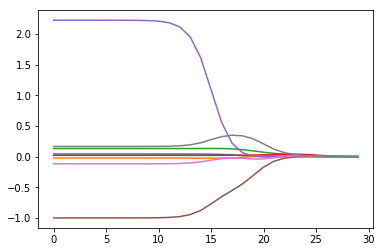

In [21]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(ws)
plt.show()

上图表示不同lambda代表不同的权重值，可以看出lambda越大，权重的variance越小

接下来介绍第二种解决过拟合的方法-lasso regression，ridge回归增加了这个限制，$\sum_{N}^{n}w_n^2\leq \lambda $，而lasso是对权重进行绝对值对操作$\sum_{N}^{n}|w_n|\leq \lambda $，ridge回归的缺点是模型变量特别多，可解释性差，lasso的好处是变量少，可解释力强，但缺点是损失函数不可导，只能用特殊的方法优化，下面我们使用常见的算法之一-前向梯度(Forward Stagewise)算法。

In [32]:
def regularize(xMat):#regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0)   #calc mean then subtract it off
    inVar = np.var(inMat,0)      #calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = regularize(xMat)
    m,n=np.shape(xMat)
    returnMat = np.zeros((numIt,n))
    ws = np.zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):
        if i%10==0:
            print(ws.T)
        lowestError = np.inf; 
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = errorfc(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

xs,ys = loadDataSet('datasets/abalone.txt')
stageWise(xs,ys,0.01,200)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.03]]
[[ 0.    0.    0.01  0.05  0.   -0.01  0.    0.11]]
[[ 0.    0.    0.01  0.05  0.   -0.07  0.    0.15]]
[[ 0.    0.    0.01  0.05  0.   -0.13  0.    0.19]]
[[ 0.    0.    0.01  0.05  0.   -0.2   0.    0.22]]
[[ 0.    0.    0.02  0.04  0.   -0.25  0.    0.25]]
[[ 0.    0.    0.03  0.04  0.   -0.3   0.    0.29]]
[[ 0.    0.    0.05  0.04  0.   -0.37  0.    0.3 ]]
[[ 0.    0.    0.06  0.04  0.   -0.43  0.    0.33]]
[[ 0.    0.    0.08  0.03  0.   -0.47  0.    0.36]]
[[ 0.01  0.    0.09  0.03  0.01 -0.53  0.    0.37]]
[[ 0.01  0.    0.09  0.03  0.08 -0.56  0.    0.37]]
[[ 0.02  0.    0.09  0.03  0.15 -0.58  0.    0.37]]
[[ 0.03  0.    0.09  0.03  0.21 -0.61  0.    0.37]]
[[ 0.04  0.    0.09  0.03  0.27 -0.63  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.   

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

可以看到$w_1$和$w_6$都是0，代表这两个是比较不重要的特征，我们发现在最后他在某个地方来回震荡，代表eps设太大了，我们调小一点

In [33]:
stageWise(xs,ys,0.001,5000)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.01 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.02 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.03 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.04 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.05 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.06 0.   0.   0.   0.  ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.   ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.01 ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.02 ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.03 ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.04 ]]
[[0.    0.    0.005 0.065 0.    0.    0.    0.05 ]]
[[0.    0.    0.005 0.063 0.    0.    0.    0.058]]
[[0.    0.    0.005 0.061 0.    0.    0.    0.066]]
[[0.    0.    0.005 0.059 0.    0.    0.    0.074]]
[[0.    0.    0.005 0.057 0.    0.    0.    0.082]]
[[0.    0.    0.005 0.055 0.    0.    0.    0.09 ]]
[[0.    0.    0.005 0.053 0.    0.    0.    0.098]]
[[0.    0.    0.005 0.05  0.    0.    0.    0.105]]
[[0.    0.    0.005 0.048 0.    

[[ 0.006  0.     0.11   0.022  0.222 -0.605 -0.011  0.37 ]]
[[ 0.006  0.     0.11   0.022  0.23  -0.606 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.237 -0.608 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.245 -0.609 -0.011  0.367]]
[[ 0.006  0.     0.11   0.022  0.252 -0.611 -0.012  0.367]]
[[ 0.007  0.     0.11   0.022  0.259 -0.611 -0.013  0.366]]
[[ 0.007  0.     0.11   0.022  0.266 -0.613 -0.013  0.365]]
[[ 0.007  0.     0.11   0.022  0.273 -0.615 -0.013  0.364]]
[[ 0.007  0.     0.11   0.022  0.281 -0.616 -0.014  0.364]]
[[ 0.007  0.     0.11   0.022  0.288 -0.618 -0.014  0.363]]
[[ 0.007  0.     0.11   0.022  0.296 -0.619 -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.302 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.31  -0.622 -0.015  0.361]]
[[ 0.008  0.     0.11   0.022  0.318 -0.622 -0.016  0.36 ]]
[[ 0.008  0.     0.11   0.022  0.325 -0.624 -0.016  0.359]]
[[ 0.008  0.     0.11   0.022  0.332 -0.627 -0.016  0.359]]
[[ 0.009  0.     0.11   0.022  0.339 -0.

[[ 0.028  0.     0.11   0.022  1.293 -0.818 -0.067  0.262]]
[[ 0.028  0.     0.11   0.022  1.301 -0.818 -0.068  0.261]]
[[ 0.028  0.     0.11   0.022  1.308 -0.82  -0.068  0.26 ]]
[[ 0.028  0.     0.11   0.022  1.316 -0.821 -0.068  0.259]]
[[ 0.029  0.     0.11   0.022  1.322 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.33  -0.824 -0.069  0.258]]
[[ 0.029  0.     0.11   0.022  1.337 -0.826 -0.069  0.257]]
[[ 0.03   0.     0.11   0.022  1.343 -0.828 -0.07   0.257]]
[[ 0.03   0.     0.11   0.022  1.351 -0.829 -0.07   0.256]]
[[ 0.03   0.     0.11   0.022  1.358 -0.83  -0.071  0.255]]
[[ 0.03   0.     0.11   0.022  1.366 -0.832 -0.071  0.255]]
[[ 0.03   0.     0.11   0.022  1.373 -0.834 -0.071  0.254]]
[[ 0.03   0.     0.11   0.022  1.381 -0.834 -0.072  0.253]]
[[ 0.03   0.     0.11   0.022  1.388 -0.836 -0.072  0.252]]
[[ 0.03   0.     0.11   0.022  1.395 -0.838 -0.072  0.251]]
[[ 0.03   0.     0.11   0.022  1.403 -0.839 -0.073  0.251]]
[[ 0.03   0.     0.11   0.022  1.41  -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])